# Figures 3c, 3d: 

**EDIT**: 
This code comes from `dimorphAS/notebook/figure4a` but corresponds to the figure **`Figure 3c, 3d`** of the publication.

## Questions:

- Are these plots only for specific tissues?
- Is the tissue defined inside the [`parseMT.pl`]() script?
- What are the `mt.txt` and `lv.txt` referring to? Is that tissues?

 - (lv <- left ventricle)
 - (mt <- mammary tissue)
 
Why only these tissues?

## **NOTE**:

We assume that you have cloned the analysis repository and have `cd` into the parent directory. Before starting with the analysis make sure you have first completed the dependencies set up by following the instructions described in the **`dependencies/README.md`** document. All paths defined in this Notebook are relative to the parent directory (repository). Please close this Notebook and start again by following the above guidelines if you have not completed the aforementioned steps.

## Loading dependencies

In [1]:
Sys.setenv(TAR = "/bin/tar") 

# dataviz dependencies
library(ggplot2)
library(visdat)
library(patchwork)
library(ggsci)
library(grid)
library(report)

# BDA2E-utilities dependencies
library(parallel)
library(rjags)
library(runjags)
library(compute.es)

Warning message:
“package ‘rjags’ was built under R version 3.6.2”Loading required package: coda
Linked to JAGS 4.3.0
Loaded modules: basemod,bugs


##  Figure 3b

code from: [dimorphAS/figures/oldFigureDrafts/figure3b.R](https://github.com/TheJacksonLaboratory/sbas/blob/master/dimorphAS/figures/oldFigureDrafts/figure3b.R)

In [2]:
source("../dimorphAS/DBDA2Eprograms/DBDA2E-utilities.R")


*********************************************************************
Kruschke, J. K. (2015). Doing Bayesian Data Analysis, Second Edition:
A Tutorial with R, JAGS, and Stan. Academic Press / Elsevier.
*********************************************************************



## Retrieving the required data

In [3]:
# Download GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct from Google Cloud 
if (!("GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct" %in% list.files("../data/"))) {
    message("Downloading GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct.gz \nfrom https://console.cloud.google.com/storage/browser/_details/gtex_analysis_v7/rna_seq_data/ ..")
    system("wget -O ../data/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct.gz https://storage.googleapis.com/gtex_analysis_v7/rna_seq_data/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct.gz", intern = TRUE)
    message("Done!\n\n")
    message("Unzipping compressed file GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct.gz..")
    system("gunzip ../data/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct.gz", intern = TRUE)
    message("Done! \n\nThe file GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct can be found in ../data/")
}

In [4]:
tissue.list<-c('Heart - Left Ventricle',
               'Breast - Mammary Tissue',
               'Brain - Cortex.Brain - Frontal Cortex (BA9).Brain - Anterior cingulate cortex (BA24)',
               'Adrenal Gland',
               'Adipose - Subcutaneous',
               'Muscle - Skeletal',
               'Thyroid',
               'Cells - Transformed fibroblasts',
               'Artery - Aorta',
               'Skin - Sun Exposed (Lower leg).Skin - Not Sun Exposed (Suprapubic)')

In [5]:
all.genes<-data.table::fread('../data/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct',
                              sep='\t',
                              header=TRUE,
                              skip=2,
                              colClasses = c(rep("character", 2), rep("NULL", 11688)))

In [6]:
dim(all.genes)
head(all.genes)

[1] 56202     2

Name,Description
<chr>,<chr>
ENSG00000223972.4,DDX11L1
ENSG00000227232.4,WASH7P
ENSG00000243485.2,MIR1302-11
ENSG00000237613.2,FAM138A
ENSG00000268020.2,OR4G4P
ENSG00000240361.1,OR4G11P


## Filtering out of duplicate trabsripts ids

In [7]:
all.genes<-all.genes[!duplicated(all.genes$Description),]

In [8]:
dim(all.genes)

[1] 54271     2

## Accessing Position Specific Scoring Matrices (in `dimorphAS/RBP/RBP_PSSMs.zip`)

In [9]:
# Download GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct from Google Cloud 
if (!("RBP_PSSMs" %in% list.files("../data/"))) {
    message("Unzipping ../dimorphAS/RBP/RBP_PSSMs.zip INTO ../data ..\n")
    system("cd ../data/ && unzip ../dimorphAS/RBP/RBP_PSSMs.zip", intern = TRUE)
    message("Done! \n\nThe files can be found in ../data/RBP_PSSMs/")
}

In [10]:
rbp.names<-unique(gsub('_.*','',list.files('../RBP_PSSMs/')))

In [11]:
length(rbp.names)

[1] 136

In [12]:
summary.tab<-matrix(ncol=7,nrow=0)

In [13]:
colnames(summary.tab)<-c('Event',
                         'Gene', 
                         'Sig. RBPs',
                         'Sig. Gene Expression',
                         'Sig. Sex',
                         'Tissue',
                         'Dimorphic')

In [14]:
top.rbps<-rbp.names

In [15]:
length(top.rbps)

[1] 136

## Initialising dataframe with columns `coef,rbp,tissue`

In [16]:
df <-data.frame(coef=NULL,rbp=NULL,tissue=NULL)

In [17]:
# Refactoring needed to not rely on hard coded by position id of tissue
tissue <- tissue.list[[1]]

In [18]:
head(tissue)

[1] "Heart - Left Ventricle"

## `{Missing files!}`  Dimorph/McmcMostVaryingMoreSigs_'

In [ ]:
load(paste('/Users/karleg/Dimorph/McmcMostVaryingMoreSigs_',tissue,'.Rdata',sep=''))
  
mcmcCoda<-mcmcCoda[,which(grepl('beta2\\[101,87\\]',varnames(mcmcCoda))),drop=FALSE]

diagMCMC( mcmcCoda , parName=c("beta2[101,87]") )  


## Using cached `.Rdata` until the files Dimorph/McmcMostVaryingMoreSigs_* are located

In [29]:
#Before running the following, use the Session menu to set working directory to source file location
#setwd(dir = "../dimorphAS/DBDA2Eprograms/")
load('../dimorphAS/figures/oldFigureDrafts/figure3b.RData')

### This invokes X11 which is not available for all systems, and won't work in a NextFlow pipeline

```
diagMCMC(mcmcCoda , parName=c("beta2[101,87]"))
```

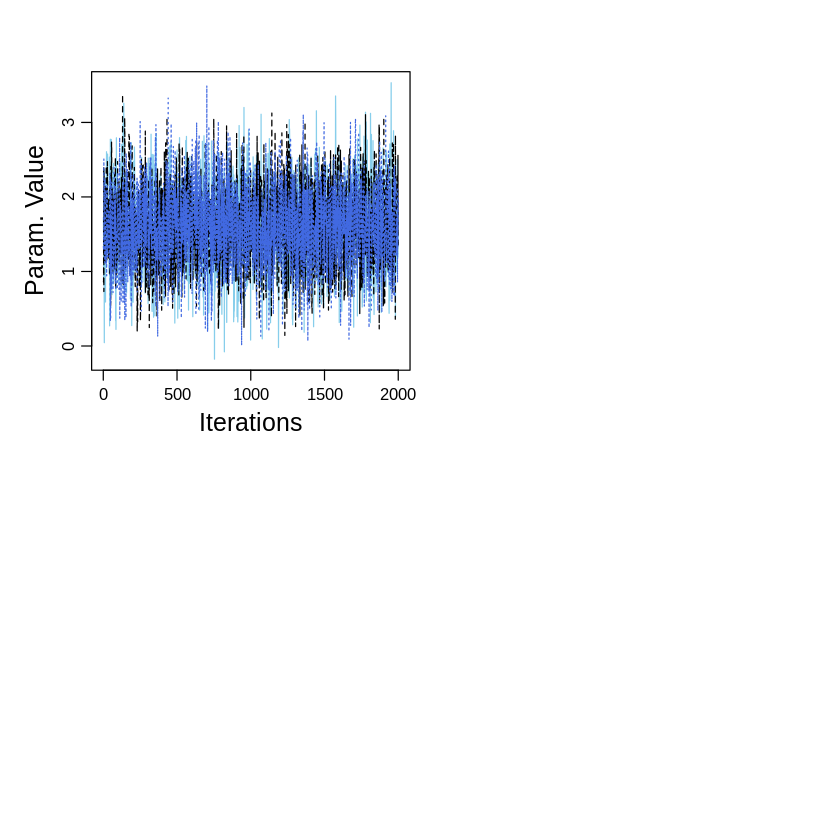

In [35]:
codaObject <- mcmcCoda 
parName    <- c("beta2[101,87]") #varnames(codaObject)[1]
saveName   <- NULL
saveType   <- "jpg"


DBDAplColors = c("skyblue",
               "black",
               "royalblue",
               "steelblue")

#openGraph(height=5,width=7)
    
par(mar=0.5+c(3,4,1,0) , 
  oma=0.1+c(0,0,2,0) , 
  mgp=c(2.25,0.7,0) , 
  cex.lab=1.5 )
    
layout(matrix(1:4,nrow=2))
  # traceplot and gelman.plot are from CODA package:
require(coda)
coda::traceplot( codaObject[,c(parName)], 
              main="" , 
              ylab="Param. Value" ,
              col=DBDAplColors )

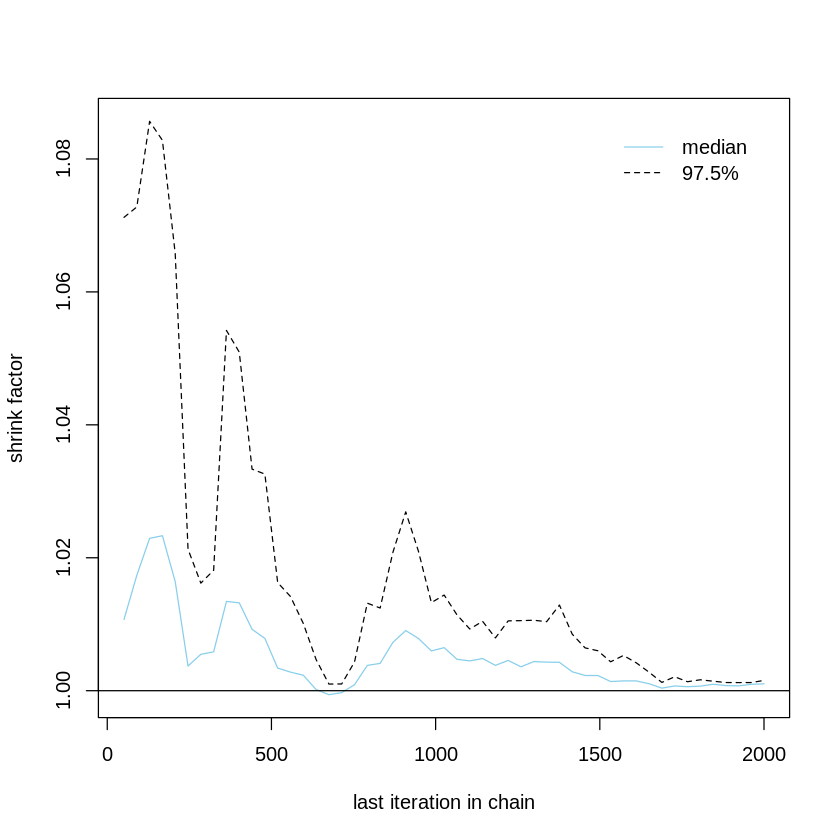

In [36]:
tryVal = try(
coda::gelman.plot(codaObject[,c(parName)] , 
                  main="",
                  auto.layout=FALSE,
                  col=DBDAplColors )
)  

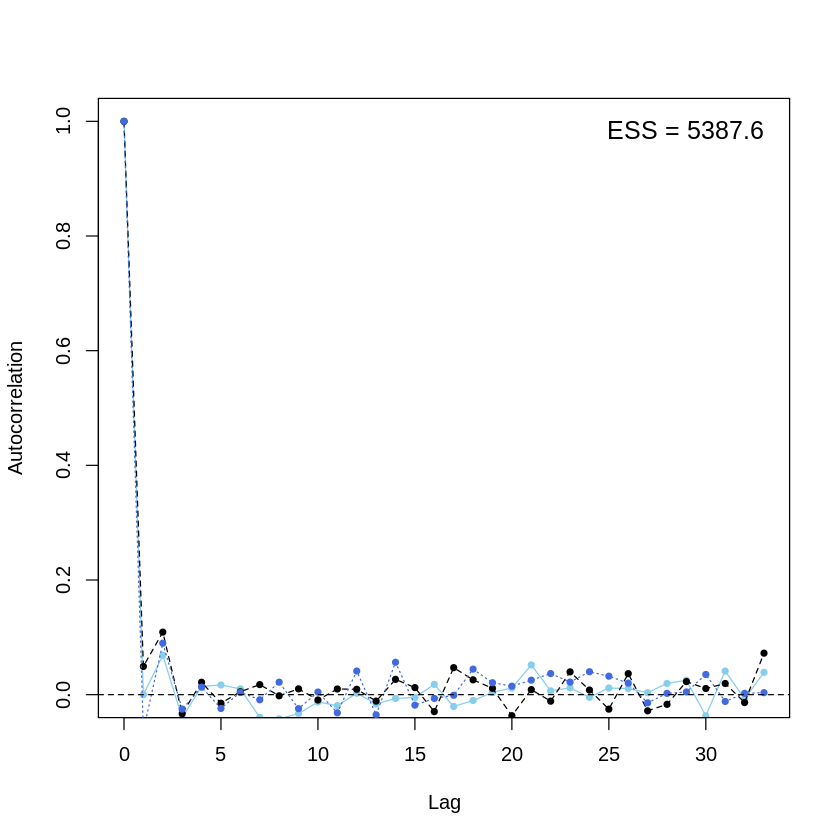

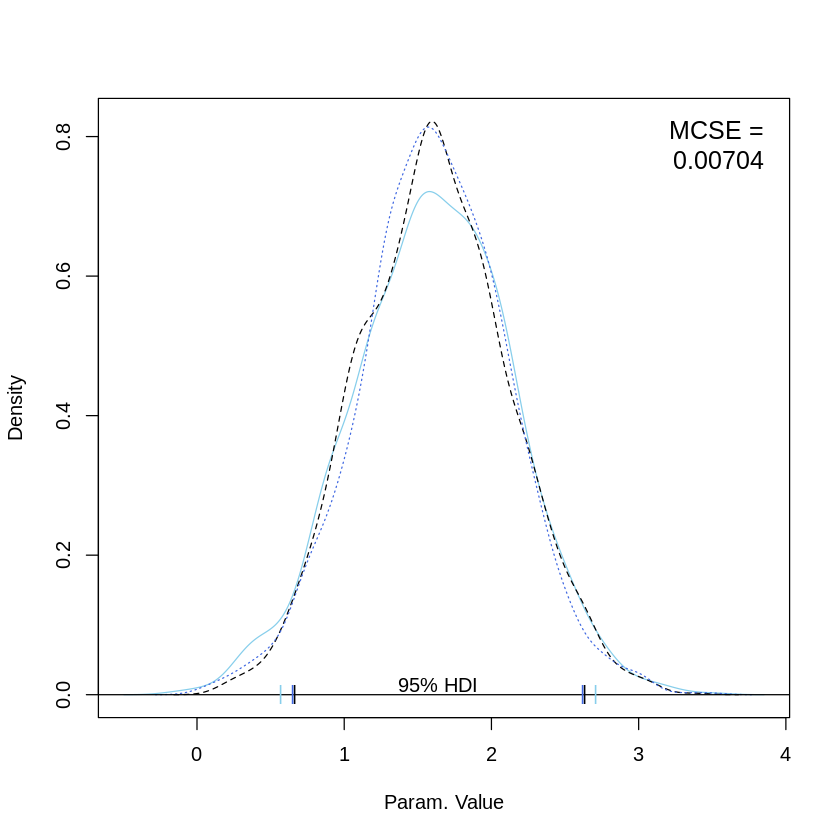

In [38]:
  # if it runs, gelman.plot returns a list with finite shrink values:
  if ( class(tryVal)=="try-error" ) {
    plot.new() 
    print(paste0("Warning: coda::gelman.plot fails for ",parName))
  } else { 
    if ( class(tryVal)=="list" & !is.finite(tryVal$shrink[1]) ) {
      plot.new() 
      print(paste0("Warning: coda::gelman.plot fails for ",parName))
    }
  }
  DbdaAcfPlot(codaObject,parName,plColors=DBDAplColors)
  DbdaDensPlot(codaObject,parName,plColors=DBDAplColors)
  mtext( text=parName , outer=TRUE , adj=c(0.5,0.5) , cex=2.0 )
  if ( !is.null(saveName) ) {
    saveGraph( file=paste0(saveName,"Diag",parName), type=saveType)
  }



##  Figure 3c
**EDIT**: 
This code comes from `dimorphAS/notebook/figure4a` but corresponds to the figure **`Figure 3c`** of the publication.

This script creates figure 4a. Please run the following command first:

`perl` [`parseMT.pl`](https://github.com/TheJacksonLaboratory/sbas/blob/master/dimorphAS/notebook/parseMT.pl)

This creates the files needed for figure `4a` and `4b`, namely `lv.txt` and `mt.txt`.
The input file for  [`parseMT.pl`](https://github.com/TheJacksonLaboratory/sbas/blob/master/dimorphAS/notebook/parseMT.pl) is a `.tsv` file name `summary_hbm.txt`. Here is a preview of this file:


In [39]:
summary_hbm   <- utils::read.table(file      = "../dimorphAS//notebook/summary_hbm.txt", 
                                   header    = TRUE, 
                                   sep       = "\t")

In [40]:
dim(summary_hbm)
head(summary_hbm, 2)

[1] 1112    7

,Event,Gene,Sig..RBPs,Sig..Gene.Expression,Sig..Sex,Tissue,Dimorphic
,<int>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>
1,21228,TANK,"CNOT4(-0.21),CPEB2(-0.11),DAZAP1(-0.14),ENOX1(-0.06),HNRNPA1(0.07),HNRNPA2B1(0.22),HNRNPCL1(-0.16),HNRNPF(0.22),HNRNPH1(0.14),HNRNPH2(0.24),KHDRBS1(0.23),KHDRBS3(-0.06),PABPC1(0.12),PABPC5(0.08),PPRC1(0.14),RBFOX1(0.19),RBM4(-0.16),RBM45(0.03),RBM46(-0.13),RBMS3(-0.07),RBP1(-0.05),SAMD4A(0.13),SRSF1(-0.23),SRSF7(-0.12),TARDBP(-0.17),U2AF2(0.25),ZC3H14(0.27)",0.29,0.16,Heart - Left Ventricle,No
2,28196,UBE2E1,"FXR1(-0.16),FXR2(-0.19),HNRNPA2B1(0.19),IGF2BP3(-0.04),KHDRBS1(-0.19),LIN28A(0.02),MSI1(0.05),PABPC3(-0.07),PABPC4(0.11),PABPN1(-0.16),PCBP2(-0.15),RBFOX1(-0.13),RBM4(-0.1),RBM45(-0.03),RBM5(0.11),RBM8A(-0.14),RBMS1(-0.19),RBMS3(0.07),SAMD4A(0.12),SRSF2(0.13),SRSF9(-0.23),U2AF2(0.14),ZC3H14(0.2),ZCRB1(0.13),ZNF638(-0.24)",0.68,0.00,Heart - Left Ventricle,No


In [41]:
if ( ("lv.txt" %in% list.files("../data/")) && ("mt.txt" %in% list.files("../data/"))) {
        message("The files lv.txt or mt.txt are available in the folder ../data/! \n")
        message("The 'perl parseMT.pl' command will not be re-run \n")
}


if ( (!("lv.txt" %in% list.files("../data/"))) | (!("mt.txt" %in% list.files("../data/")))) {
        message("The files lv.txt or mt.txt not found in the folder ../data/ \n")
        message("Generating lv.txt and mt.txt with 'perl parseMT.pl' using 'summary_hbm.txt' as input .. \n")
        system(paste0("cd ../dimorphAS/notebook/ && ",
                      "perl parseMT.pl > parseMT_output.txt && ", 
                      "mv lv.txt ../../data/ && ",
                      "mv mt.txt ../../data/ && ",
                      "cp summary_hbm.txt  ../../data/"), 
               intern  = TRUE)
        message("Done!\n")
}



The files lv.txt or mt.txt not found in the folder ../data/ 

Generating lv.txt and mt.txt with 'perl parseMT.pl' using 'summary_hbm.txt' as input .. 

Done!



# {placeholder }

Description what does the following code block do

In [42]:
dat           <- utils::read.table("../data/lv.txt", header=FALSE, sep = "\t", col.names = c("RBP", "Expression"))

In [43]:
dim(dat)
summary(dat)

[1] 96  2

      RBP          Expression     
 Min.   : 0.74   Min.   :-1.9400  
 1st Qu.: 1.85   1st Qu.:-0.9425  
 Median : 2.68   Median : 0.0000  
 Mean   : 3.46   Mean   :-0.4017  
 3rd Qu.: 4.46   3rd Qu.: 0.0000  
 Max.   :11.44   Max.   : 0.5200  

## Remove rows where expression values are equal to 0

In [44]:
d2<-dat[dat$Expression!=0,]
d2<-d2[order(d2$Expression),]

In [45]:
dim(d2)
summary(d2)

[1] 37  2

      RBP          Expression    
 Min.   :0.970   Min.   :-1.940  
 1st Qu.:1.860   1st Qu.:-1.370  
 Median :2.970   Median :-1.110  
 Mean   :3.506   Mean   :-1.042  
 3rd Qu.:4.530   3rd Qu.:-0.830  
 Max.   :9.570   Max.   : 0.520  


0.39% of rows in the dataframe were filtered out because they contained 0 values



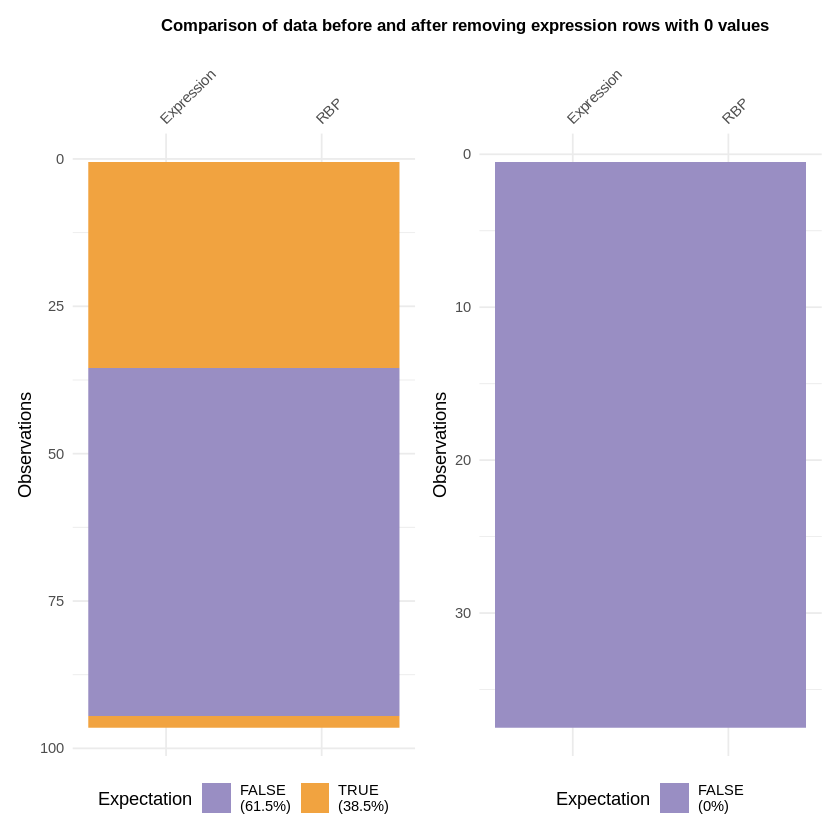

In [46]:
dat <- dat[order(dat$Expression),]
with_zeros <- visdat::vis_expect(dat, ~dat$Expression != 0,  show_perc = TRUE)
no_zeros   <- visdat::vis_expect(d2, ~d2$Expression != 0, show_perc = TRUE)
both <- with_zeros + no_zeros

message(paste0("\n", round((nrow(d2)/nrow(dat)), 2),"% ","of rows in the dataframe were filtered out because they contained 0 values\n"))

both + labs(title = "Comparison of data before and after removing expression rows with 0 values") + theme(plot.title    = element_text(size = 10, face = "bold" , hjust = 1.2))

We are checking above if our expectation of having none 0 Expression values is true. We can also verify this by the initial and final row count of the dataframe that contains the `RBP` and `Expression` values.

## Fit a linear model (`expression ~ rbm`)

In [47]:
lm_fit   <- lm(d2$Expression ~ d2$RBP, data=d2)
LM       <-summary(lm_fit)
rsquared <-round(LM$r.squared,digits=2)

In [48]:
lm <- report(lm_fit)
lm$texts$text_long
lm$tables$table_long

We fitted a linear model (estimated using OLS) to predict d2$Expression with d2 and RBP (formula = d2$Expression ~ d2$RBP). Standardized parameters were obtained by fitting the model on a standardized version of the dataset. Effect sizes were labelled following Funder's (2019) recommendations.

The model explains a significant and substantial proportion of variance (R2 = 0.35, F(1, 35) = 19.10, p < .001, adj. R2 = 0.33). The model's intercept, corresponding to , is at -1.52 (SE = 0.13, 95% CI [-1.79, -1.26], p < .001). Within this model:

  - The effect of d2$RBP is positive and can be considered as very small and significant (beta = 0.14, SE = 0.03, 95% CI [0.07, 0.20], std. beta = 0.14, p < .001).

Parameter,Coefficient,SE,CI_low,CI_high,t,df_error,p,Std_Coefficient,Fit
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
(Intercept),-1.5241806,0.13064990,-1.7894140,-1.2589471,-11.666144,35,1.296862e-13,-1.5241806,NA
d2$RBP,0.1374966,0.03146206,0.0736252,0.2013679,4.370235,35,1.056443e-04,0.1374966,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
AIC,NA,NA,NA,NA,NA,NA,NA,NA,45.7960906
BIC,NA,NA,NA,NA,NA,NA,NA,NA,50.6288443
R2,NA,NA,NA,NA,NA,NA,NA,NA,0.3530374
R2 (adj.),NA,NA,NA,NA,NA,NA,NA,NA,0.3345527
RMSE,NA,NA,NA,NA,NA,NA,NA,NA,0.4143047


## Save predictions of the model 
Save predictions of the model in a new data frame named `predicted_df` along with the variable we want to plot against.

In [49]:
predicted_df <- data.frame(expr_pred = predict(lm_fit, d2), RBP=d2$RBP)

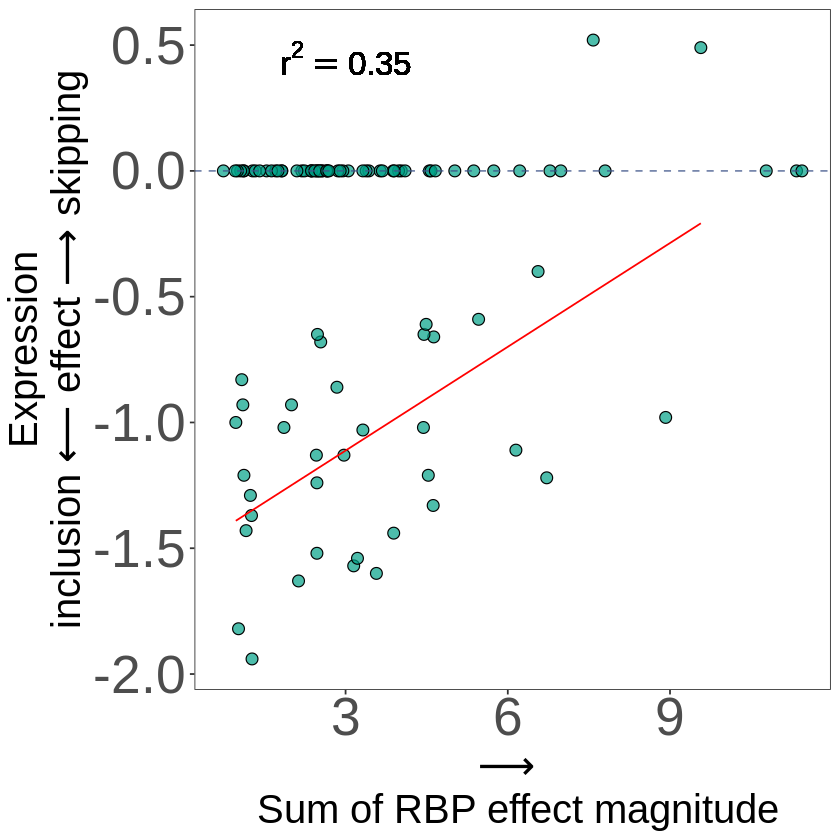

In [50]:
mypal <- ggsci::pal_npg("nrc", alpha = 0.7)(9)


p<-ggplot(dat, aes(x=RBP, y=Expression)) + geom_point(shape=21,fill = mypal[3],size=3) +  theme_bw()
#+ scale_fill_npg() 
p <- p + theme(axis.text = element_text(size=32, hjust=0.5),
               axis.title.x=element_text(size=24),
               axis.title.y = element_text(size=24),
               axis.text.y = element_text(size=32),
               panel.grid.major = element_blank(), 
               panel.grid.minor = element_blank()) 
p <- p +  geom_hline(yintercept=0, linetype="dashed", color = mypal[4])
p <- p +xlab('\U27F6 \n Sum of RBP effect magnitude')+ylab('Expression\ninclusion \U27F5 effect \U27F6 skipping')
p <- p+ geom_line(color='red',data = predicted_df, aes(y=expr_pred, x=RBP))
mylabel<-paste(italic(r)^2~"="~rsquared) 
p <- p+ geom_text(x = 3, y = 0.45, label = as.character(paste( "r^2==",rsquared)), size=7, parse = TRUE)
p

### (3c) Predicted effects of gene expression vs. RBP levels on exon inclusion in 100 sex-biased SE events in the left ventricle. 

The Y axis shows the mean of the posterior of the coefficient that determines the effects of gene expression on exon inclusion. 
Negative values favour skipping and positive values favour inclusion. 
The X axis shows the sum of the absolute values of the posterior of the coefficients of the 87 RBPs. 
The higher the value, the more the predicted effect on exon skipping. 
In the left frame it can be seen that for 61 out of 100 sex-biased events in left ventricle, 
no effect of gene expression was predicted (flat line at y=0.0). 

For the remaining genes there was a correlation with **`R2=0.35 (p=7.98x10-5).`**

##  Figure 4b


This should be run after the `figure4a.R` script (see above code chunks) 

In [51]:
dat <- read.table("../data/mt.txt", header=FALSE, sep = "\t", col.names = c("RBP", "Expression"))

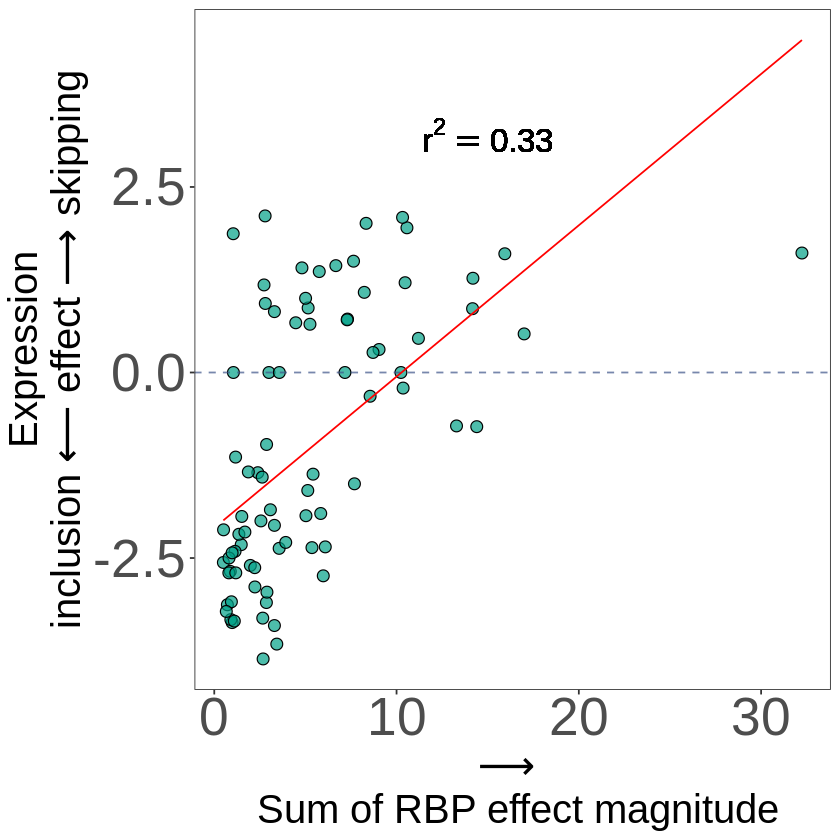

In [52]:
mypal = pal_npg("nrc", alpha = 0.7)(9)
d2<-dat[dat$Expression!=0,]
lm_fit <- lm(d2$Expression ~ d2$RBP, data=d2)
LM<-summary(lm_fit)
rsquared<-round(LM$r.squared,digits=2)  

# save predictions of the model in the new data frame 
# together with variable you want to plot against
predicted_df <- data.frame(expr_pred = predict(lm_fit, d2), RBP=d2$RBP)


p<-ggplot(dat, aes(x=RBP, y=Expression)) + geom_point(shape=21,fill = mypal[3],size=3) +  theme_bw()
 #+ scale_fill_npg() 
p <- p + theme(axis.text = element_text(size=32, hjust=0.5),
               axis.title.x=element_text(size=24),
               axis.title.y = element_text(size=24),
               axis.text.y = element_text(size=32),
               panel.grid.major = element_blank(), 
               panel.grid.minor = element_blank()) 
p <- p +  geom_hline(yintercept=0, linetype="dashed", color = mypal[4])
p <- p +xlab('\U27F6 \n Sum of RBP effect magnitude')+ylab('Expression\ninclusion \U27F5 effect \U27F6 skipping')
p <- p+ geom_line(color='red',data = predicted_df, aes(y=expr_pred, x=RBP))
mylabel<-paste(italic(r)^2~"="~rsquared) 
p <- p+ geom_text(x = 15, y = 3.2, label = as.character(paste( "r^2==",rsquared)), size=7, parse = TRUE)
p

## (3d) A similar correlation was found in mammary tissue, with R2=0.33 (p=3.6x10-12).


## Metadata

For replicability and reproducibility purposes, we also print the following metadata:

1. Checksums of **'artefacts'**, files generated during the analysis and stored in the folder directory **`data`**
2. List of environment metadata, dependencies, versions of libraries using `utils::sessionInfo()` and [`devtools::session_info()`](https://devtools.r-lib.org/reference/session_info.html)

### 1. Checksums with the sha256 algorithm

In [57]:
figure_id       <- "figures_3"

message("Generating sha256 checksums of the artefacts in the `..data/` directory .. ")
system(paste0("cd ../data/ && find . -type f -exec sha256sum {} \\; > ../metadata/",  figure_id, "_sha256sums.txt"), intern = TRUE)
message("Done!\n")

data.table::fread(paste0("../metadata/", figure_id, "_sha256sums.txt"), header = FALSE, col.names = c("sha256sum", "file"))

Generating sha256 checksums of the artefacts in the `..data/` directory .. 


character(0)

Done!



sha256sum,file
<chr>,<chr>
947b61563e51232c3276cd4b44d3414d68ea9a419dc74d09375d2bfbb321f08b,./summary_hbm.txt
51664e9a360820d0b6ce1918f8959694c0531643fc08af6ec1c18eb1d58275f6,./lv.txt
127d4583e12f59c4e20aff02994325a7287adbdb8a7920b324d9dc443f275de6,./RBP_PSSMs/IGF2BP3_amahwca_human_PSSM.txt
f11baa5121ab75f57c5e217aa0884a7f77b7053d2741a9cb3cd7aa106b8e111d,./RBP_PSSMs/BRUNOL5_ugugukk_human_PSSM.txt
9b25a7513026b747e3c43c685da02befa71c7dc86487e629a1f7b5e177520578,./RBP_PSSMs/PCBP1_ccwwhcc_human_PSSM.txt
83587a10b97e1c4d8aa32abd4fbd660bde98cfcc84c83470038302d114e0a76d,./RBP_PSSMs/SFPQ_kurrukk_human_PSSM.txt
b46007476fd8d740f51273d4d2617b2c45f3e4b018f995d00ba10885d52a5b71,./RBP_PSSMs/U2AF50_uuuuuyy_drosophila_PSSM.txt
65aca0226331c3778b8cb8a03aea736f2909da95db2b2c3a852b875cc5056d75,./RBP_PSSMs/RBM42_aacuamg_human_PSSM.txt
a638828097c5850d6d96c2ed98ef3a10bdceae71c303ef47686d927c56ee8d59,./RBP_PSSMs/SNF_uwgcac_drosophila_PSSM.txt


### 2. Libraries metadata

In [58]:
dev_session_info   <- devtools::session_info()
utils_session_info <- utils::sessionInfo()

message("Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..")
saveRDS(dev_session_info, file = paste0("../metadata/", figure_id, "_devtools_session_info.rds"))
message("Done!\n")

message("Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..")
saveRDS(utils_session_info, file = paste0("../metadata/", figure_id ,"_utils_info.rds"))
message("Done!\n")

dev_session_info$platform
dev_session_info$packages[dev_session_info$packages$attached==TRUE, ]

Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..
Done!

Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..
Done!



 setting  value                       
 version  R version 3.6.1 (2019-07-05)
 os       Ubuntu 18.04.3 LTS          
 system   x86_64, linux-gnu           
 ui       X11                         
 language en_US.UTF-8                 
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       Etc/UTC                     
 date     2020-03-02                  

,package,ondiskversion,loadedversion,path,loadedpath,attached,is_base,date,source,md5ok,library
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<fct>
coda,coda,0.19.3,0.19-3,/opt/conda/lib/R/library/coda,/opt/conda/lib/R/library/coda,TRUE,FALSE,2019-07-05,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
compute.es,compute.es,0.2.4,0.2-4,/opt/conda/lib/R/library/compute.es,/opt/conda/lib/R/library/compute.es,TRUE,FALSE,2014-09-16,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
ggplot2,ggplot2,3.2.1,3.2.1,/opt/conda/lib/R/library/ggplot2,/opt/conda/lib/R/library/ggplot2,TRUE,FALSE,2019-08-10,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
ggsci,ggsci,2.9,2.9,/opt/conda/lib/R/library/ggsci,/opt/conda/lib/R/library/ggsci,TRUE,FALSE,2018-05-14,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
patchwork,patchwork,1.0.0,1.0.0,/opt/conda/lib/R/library/patchwork,/opt/conda/lib/R/library/patchwork,TRUE,FALSE,2019-12-01,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
report,report,0.1.0,0.1.0,/opt/conda/lib/R/library/report,/opt/conda/lib/R/library/report,TRUE,FALSE,2020-03-02,Github (easystats/report@dcdd283),NA,/opt/conda/lib/R/library
rjags,rjags,4.10,4-10,/opt/conda/lib/R/library/rjags,/opt/conda/lib/R/library/rjags,TRUE,FALSE,2019-11-06,CRAN (R 3.6.2),NA,/opt/conda/lib/R/library
runjags,runjags,2.0.4.6,2.0.4-6,/opt/conda/lib/R/library/runjags,/opt/conda/lib/R/library/runjags,TRUE,FALSE,2019-12-17,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
visdat,visdat,0.5.3,0.5.3,/opt/conda/lib/R/library/visdat,/opt/conda/lib/R/library/visdat,TRUE,FALSE,2019-02-15,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
